# Comparison of results from different algrithms and input sets

In this notebook we will compare the metrics output by training and evaluation runs of each of the definition files in [the examples directory](https://github.com/MetOffice/XBTs_classification/tree/master/examples) on GitHub. We will compare the per year recall for each algorthm/input features combo as well as looking at the overall scores to choose a best classification pipeline to recommend for use with the EN4 dataset.

### Environment and library setup
The results are stored in CSV files, so we will use pandas and matplotlib to load and visualise the metrics. 

In [1]:
import pandas
import os
import sys
from pathlib import Path
import functools
import re

In [2]:
import matplotlib
import matplotlib.pyplot

In [3]:
font = {'family' : 'normal',
        'size'   : 32}
matplotlib.rc('font', **font)
matplotlib.pyplot.style.use('ggplot')

In [4]:
import sklearn.metrics

In [5]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [6]:
root_data_dirs = {
    'MO_scitools': '/scratch/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}


In [7]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [8]:
input_dir_name = 'csv_with_imeta'
plot_dir_name = 'plots'
exp_out_dir_name = 'journal_paper_202104'
imeta_dir = 'imeta'

In [9]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name)
xbt_imeta_path   = os.path.join(xbt_output_dir, imeta_dir)
xbt_plots_dir = os.path.join('/data/users/shaddad/xbt-data/', plot_dir_name)

# Finding the results files
The experiment output directory is arranged as one output directory per experiment definition file. Each directory will have:
* `xbt_metrics_<experiment_name>_<datestamp>.json` - the CSV file with per year and per instrument metrics
* `xbt_score_<experiment_name>_<datestamp>.json` - the CSV file with average metrics for all data in train and test sets.
* `xbt_classifications_<experiment_name>.csv`  -  a file containing the input data as well as the classifcation produced with the classifier trained in the experiment.
* `xbt_classifier_<RandomForest_country>_<split_num>.joblib` - one file for each outer split, containing the saved state of the classifier trained on that split.
* `xbt_param_<experiment_name>_inference.json` - The experiment definition file used for this experiment, with the addition of a list of classifier state file. This file should be used to run the inference script with classifiers that have been trained in this experiment.

The code below find all the metrics and score result files and extracts relevant subsets into dataframes for plotting.

In [10]:
metrics_prefix = 'xbt_metrics'
score_prefix = 'xbt_score'

In [11]:
regex_metrics_files = metrics_prefix + '_(?P<classifier>([a-zA-Z]+))_(?P<features>([a-zA-Z]+))(_cv)*_(?P<timestamp>[0-9_]+)'
regex_score_files = score_prefix + '_(?P<classifier>([a-zA-Z]+))_(?P<features>([a-zA-Z]+))(_cv)*_(?P<timestamp>[0-9_]+)'

In [12]:
imeta_metrics = pandas.read_csv(os.path.join(xbt_imeta_path, 'xbt_metrics_imeta.csv'))                             

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/shaddad/xbt-data/journal_paper_202104/imeta/xbt_metrics_imeta.csv'

In [ ]:
metric_tuples1 = [ (dir_list[0], sorted([fname1 for fname1 in dir_list[2] if 'xbt_metrics' in fname1])[-1]) for dir_list in os.walk(xbt_output_dir) if len([fname1 for fname1 in dir_list[2] if 'xbt_metrics' in fname1]) > 0]
metric_tuples1 = [(i1[0],i1[1], re.search(regex_metrics_files, i1[1])) for i1 in metric_tuples1]

In [ ]:
metrics_files_dict = {'{0}_{1}'.format(t1[2].group('classifier'), t1[2].group('features')): 
 {
    'classifier': t1[2].group('classifier'),
    'features': t1[2].group('features'),
    'timestamp': t1[2].group('timestamp'),
    'dir': t1[0],
    'fname': t1[1],
     'path': os.path.join(t1[0], t1[1]),
 }
    for t1 in metric_tuples1 if t1[2] is not None}

In [ ]:
metrics_list = {k1: pandas.read_csv(v1['path']) for k1, v1 in metrics_files_dict.items()}

In [ ]:
metrics_ens = {k1: v1[[c1 for c1 in v1.columns if 'ens' in c1 and 'recall' in c1] + ['year']] for k1,v1 in metrics_list.items()}


Here we find the recall for each classifier per year for each experiment and each split in that experiment, as well as the average recall across all split, for training and test data.

In [13]:
metrics_train_perClassifier = {
    k1: pandas.merge(v1[[i1 for i1 in v1.columns if ('_all' in i1 and 'recall_' in i1 and 'train_' in i1) or ('year' == i1)]],
                  pandas.DataFrame({'year': v1['year'], k1 + '_mean': v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'train_' in i1]].mean(axis=1)})) 
      for k1,v1 in metrics_list.items()}

metrics_test_perClassifier = {
    k1: pandas.merge(v1[[i1 for i1 in v1.columns if ('_all' in i1 and 'recall_' in i1 and 'test_' in i1) or ('year' == i1)]],
                  pandas.DataFrame({'year': v1['year'], k1 + '_mean': v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'test_' in i1]].mean(axis=1)})) 
      for k1,v1 in metrics_list.items()}


NameError: name 'metrics_list' is not defined

In [14]:
metrics_cons_train1 = functools.reduce(lambda df1,df2: pandas.merge(df1,df2,on='year'), 
       [pandas.DataFrame({'year': v1['year'], k1: v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'train_' in i1]].mean(axis=1)}) 
      for k1,v1 in metrics_list.items()]) 
metrics_cons_test1 = functools.reduce(lambda df1,df2: pandas.merge(df1,df2,on='year'), 
       [pandas.DataFrame({'year': v1['year'], k1: v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'test_' in i1]].mean(axis=1)}) 
      for k1,v1 in metrics_list.items()]) 

NameError: name 'metrics_list' is not defined

In addition to results for individual classifiers, we are also interested in the recall for the ensemble vote-based probability classifier, which is extract here.

In [15]:
#creating more descriptive names
d1_rename = {
    'RandomForest_country': 'RandomForest_countryMaxDepthYear',
    'RandomForest_countryLatLon': 'RandomForest_countryLatLonMaxDepthYear',
    'decisionTree_country': 'decisionTree_countryMaxDepthYear',
    'decisionTree_countryLatLon': 'decisionTree_countryLatLonMaxDepthYear',
    'decisionTree_latLon': 'decisionTree_latLonMaxDepthYear',
    'decisionTree_maxDepthYear': 'decisionTree_maxDepthYear',
    'decisionTree_country': 'decisionTree_countryMaxDepthYear',
    'knn_country': 'knn_countryMaxDepthYear',
    'RandomForest_country': 'RandomForest_countryMaxDepthYear',
    'logreg_country': 'logreg_countryMaxDepthYear',
    'mlp_country': 'RandomForest_countryMaxDepthYear',
    'mlp_countryLatLon': 'mlp_countryLatLonMaxDepthYear',
}
clf_list = [d1_rename[i1] for i1 in metrics_list.keys()]

NameError: name 'metrics_list' is not defined

In [16]:
d1 = {k1: m1['recall_ens_unseen_all'] for k1,m1 in metrics_list.items()}
d1.update({'year': metrics_list[list(metrics_list.keys())[0]]['year']})
metrics_recall_ens_unseen = pandas.DataFrame(d1)
metrics_recall_ens_unseen = metrics_recall_ens_unseen.rename(columns=d1_rename)

NameError: name 'metrics_list' is not defined

In [17]:
metrics_recall_ens_unseen

NameError: name 'metrics_recall_ens_unseen' is not defined

## Results from different classifiers

Here we compare the recall metric for the different classifiers used and different input features.

In [18]:
metrics_recall_ens_unseen.columns

NameError: name 'metrics_recall_ens_unseen' is not defined

In [19]:
clf_list

NameError: name 'clf_list' is not defined

In [20]:
metrics_recall_ens_unseen.columns

NameError: name 'metrics_recall_ens_unseen' is not defined

NameError: name 'metrics_recall_ens_unseen' is not defined

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


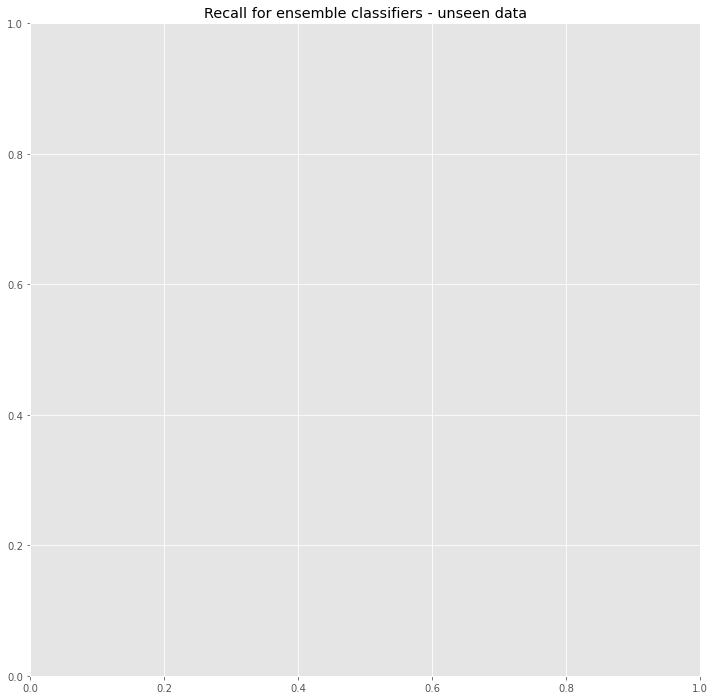

In [21]:
fig_ens_recall = matplotlib.pyplot.figure('results_ens_unseen', figsize=(12,12))
ax_ens_recall = fig_ens_recall.add_subplot(1,1,1, title='Recall for ensemble classifiers - unseen data')

metrics_recall_ens_unseen.plot.line(x='year', 
                                    y= [c1 for c1 in clf_list],
                                    ylim=[0.5, 0.1], 
                                    ax=ax_ens_recall,
                                    c='grey'
                                   )

imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_ens_recall, ylim=[0.5, 1.0], linewidth=4)
fig_ens_recall.savefig(os.path.join(xbt_plots_dir, 'recall_ens_unseen_byYear.png'))

In [22]:
num_rows = len(metrics_cons_train1.keys())
ylim = [0.5,1.01]

fig_results = matplotlib.pyplot.figure('results1', figsize=(16, 8*(num_rows+1)))
ax_train = fig_results.add_subplot(num_rows+1, 2, 1, title='Recall training data')
metrics_cons_train1.plot.line(x='year', ax=ax_train, ylim=ylim)
ax_test = fig_results.add_subplot(num_rows+1, 2, 2, title='Recall test data')
metrics_cons_test1.plot.line(x='year', ax=ax_test, ylim=ylim)

imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_train, ylim=ylim)
imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_test, ylim=ylim)

ix1 = 1
for k1, v1 in metrics_train_perClassifier.items():
    ax_train = fig_results.add_subplot(num_rows+1, 2 , ix1*2 + 1, title='Recall training {0}'.format(k1))
    v1.plot.line(x='year', ax=ax_train, ylim=[0.5,1.1],c='b',alpha=0.7)
    metrics_ens[k1].plot.line(x='year', y='recall_ens_working_all', ax=ax_train,c='r',linewidth=2.0)
    imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_train, ylim=ylim, c='g')
    ix1 += 1
ix1 = 1    
for k1, v1 in metrics_test_perClassifier.items():
    ax_test = fig_results.add_subplot(num_rows+1, 2, ix1*2 + 2, title='Recall test {0}'.format(k1))
    v1.plot.line(x='year', ax=ax_test, ylim=[0.5,1.1],c='b',alpha=0.7)
    metrics_ens[k1].plot.line(x='year', y='recall_ens_unseen_all', ax=ax_test,c='r',linewidth=2.0)
    imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_test, ylim=ylim,c='g')
    ix1 += 1
    


NameError: name 'metrics_cons_train1' is not defined

What graphs and tables do we want to show here to justify our decision of which classifier type and what set of input features we are recommending to use?

* averages for each classifier
* show all member, average and max prob metrics for each classifier
* compare to imeta baseline for each
* come up with one number for each classifier to choose the best classifier.

Other questions:
* Do we want to compare per class performance
* more analysis of per cruise performance

## And now, the winner is...

In order to select a classifier to use, we need to choose a metric to rank them on. We have chosen the recall for the ensemble classifier on the unseen data as best representing which classifier will perform best on the unlabelled data.

In [23]:
score_tuples1 = [ (dir_list[0], sorted([fname1 for fname1 in dir_list[2] if score_prefix in fname1])[-1]) for dir_list in os.walk(xbt_output_dir) if len([fname1 for fname1 in dir_list[2] if score_prefix in fname1]) > 0]
score_tuples1 = [(i1[0],i1[1], re.search(regex_score_files, i1[1])) for i1 in score_tuples1]

In [24]:
scores_files_dict = {'{0}_{1}'.format(t1[2].group('classifier'), t1[2].group('features')): 
 {
    'classifier': t1[2].group('classifier'),
    'features': t1[2].group('features'),
    'timestamp': t1[2].group('timestamp'),
    'dir': t1[0],
    'fname': t1[1],
     'path': os.path.join(t1[0], t1[1]),
 }
    for t1 in score_tuples1}

In [25]:
scores_list = {k1: pandas.read_csv(v1['path']) for k1, v1 in scores_files_dict.items()}

In [26]:
current_metric = 'recall_all'

In [27]:
current_subset = 'train'
functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_list.items()])

,name,RandomForest_countryLatLon,decisionTree_countryLatLon,decisionTree_latLon,mlp_countryLatLon,logreg_country
0,ens_working,0.972589,0.982580,0.985867,0.912931,0.789005
1,train_0,0.976222,0.948750,0.984740,0.887112,0.813420
2,train_1,0.972116,0.980233,0.966139,0.902056,0.783994
3,train_2,0.972551,0.980869,0.966617,0.902600,0.780926


In [28]:
current_subset = 'test'
functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_list.items()])

,name,RandomForest_countryLatLon,decisionTree_countryLatLon,decisionTree_latLon,mlp_countryLatLon,logreg_country
0,test_0,0.879548,0.980797,0.913534,0.911796,0.716188
1,test_1,0.941260,0.936086,0.984693,0.916774,0.796469
2,test_2,0.940668,0.933667,0.986182,0.899764,0.801108


In [29]:
current_subset = 'unseen'
recall_unseen_df = functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_list.items()])
recall_unseen_df

,name,RandomForest_countryLatLon,decisionTree_countryLatLon,decisionTree_latLon,mlp_countryLatLon,logreg_country
0,ens_unseen,0.946560,0.940416,0.850877,0.918764,0.808023
1,unseen_0,0.945510,0.926800,0.834972,0.915790,0.820546
2,unseen_1,0.943668,0.928664,0.832906,0.909484,0.806070
3,unseen_2,0.944930,0.929058,0.840067,0.899958,0.804601


In [30]:
alg_name_lut = {'RandomForest_countryLatLon': 'Random Forest',
                'decisionTree_countryLatLon': 'Decision Tree',
                'decisionTree_latLon': 'DT (no country)',
                'mlp_countryLatLon': 'Neural Network',
                'logreg_country': 'Logistic Regression',
               }

In [31]:
metrics_plot_df = pandas.DataFrame.from_records([{
    'algorithm': k1, 
    'algorithm_name': alg_name_lut[k1],
    'recall': float(s1[s1.name == 'ens_unseen']['recall_all']),
    'precision': float(s1[s1.name == 'ens_unseen']['precision_all']),
    'f1': float(s1[s1.name == 'ens_unseen']['f1_all']),
} for k1, s1 in scores_list.items()])


In [32]:
metrics_plot_df

,algorithm,algorithm_name,recall,precision,f1
0,RandomForest_countryLatLon,Random Forest,0.946560,0.946560,0.946560
1,decisionTree_countryLatLon,Decision Tree,0.940416,0.940416,0.940416
2,decisionTree_latLon,DT (no country),0.850877,0.850877,0.850877
3,mlp_countryLatLon,Neural Network,0.918764,0.918764,0.918764
4,logreg_country,Logistic Regression,0.808023,0.808023,0.808023


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


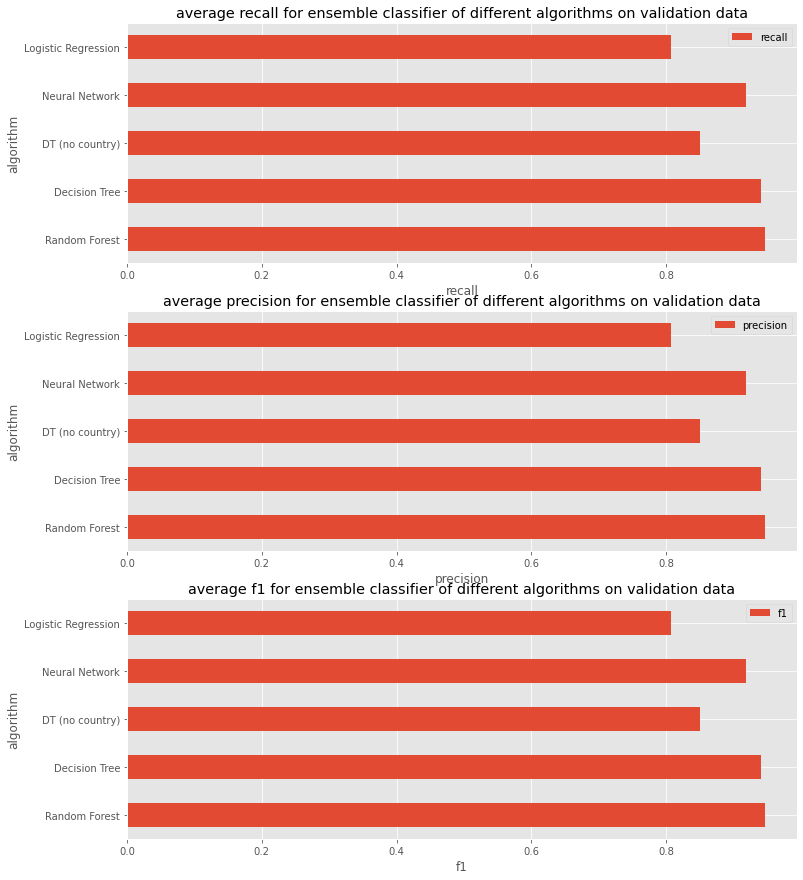

In [33]:
fig_avg_metrics = matplotlib.pyplot.figure('avg_recall', figsize=(12,15))
ax_avg_recall = fig_avg_metrics.add_subplot(3,1,1, title='average recall for ensemble classifier of different algorithms on validation data')
metrics_plot_df.plot.barh(x='algorithm_name', y='recall', ax=ax_avg_recall)
ax_avg_recall.set_ylabel('algorithm')
ax_avg_recall.set_xlabel('recall')

ax_avg_precision = fig_avg_metrics.add_subplot(3,1,2, title='average precision for ensemble classifier of different algorithms on validation data')
metrics_plot_df.plot.barh(x='algorithm_name', y='precision', ax=ax_avg_precision)
ax_avg_precision.set_ylabel('algorithm')
ax_avg_precision.set_xlabel('precision')


ax_f1_precision = fig_avg_metrics.add_subplot(3,1,3, title='average f1 for ensemble classifier of different algorithms on validation data')
metrics_plot_df.plot.barh(x='algorithm_name', y='f1', ax=ax_f1_precision)
ax_f1_precision.set_ylabel('algorithm')
ax_f1_precision.set_xlabel('f1')

fig_avg_metrics.savefig(os.path.join(xbt_plots_dir,                 
                                    'xbt_avg_ens_metrics_unseen_classifierComparison.png'),bbox_inches='tight')
